# PDE-Based Neural Network

## Import packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time

## User defined neural network
* A fully-connected feed-forward network
    * **n_input** - dimension of input, 2 in this case(x and y lcation)
    * **n_output** - dimension of output, 1 in this case (u - horizontal or v - vertical displacemnt)
    * **n_layer** - number of hidden layers
    * **n_nodes** - number of nodes of each hidden layer
* **two networks are defined seperately for u and v**

In [2]:
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer
        
        self.Input = nn.Linear(n_input, n_nodes)   # linear layer
        nn.init.xavier_uniform_(self.Input.weight) # wigths and bias initiation
        nn.init.normal_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)
        
        self.Hidden = nn.ModuleList() # hidden layer list
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)
        

    def forward(self, x):
        y = torch.tanh(self.Input(x)) # tanh activation function
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y

## Functions for first and sencod partial derivtives

In [3]:
def derivative(x, Net, func, order):
    
    w = Net(x)*func(x).view(-1,1)
    
    if order == '0':
        return w
    
    else:
        dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), 
                                    retain_graph=True, create_graph=True, allow_unused=True)
        dw_x = dw_xy[0][:,0].view(-1,1)
        dw_y = dw_xy[0][:,1].view(-1,1)
        
        if order == '1':
            return w, dw_x, dw_y
    
        else:
            dw_xxy = torch.autograd.grad(dw_x, x, torch.ones_like(dw_x), 
                                         retain_graph=True, create_graph=True,allow_unused=True)
            dw_xx = dw_xxy[0][:,0].view(-1,1)
            dw_xy = dw_xxy[0][:,1].view(-1,1)
            dw_yy = torch.autograd.grad(dw_y, x, torch.ones_like(dw_y), retain_graph=True, 
                                        create_graph=True,allow_unused=True)[0][:,1].view(-1,1)
            return w, dw_x, dw_y, dw_xx, dw_yy, dw_xy

## Construct the loss of PDE and boundary condition

In [4]:
def PDE(x, Net_u, func_u, Net_v, func_v):
    
    _, _, _, du_xx, du_yy, du_xy = derivative(x, Net_u, func_u, '2') 
    _, _, _, dv_xx, dv_yy, dv_xy = derivative(x, Net_v, func_v, '2')
    
    du_xx, du_yy, du_xy = du_xx/a, du_yy*a/b**2, du_xy/b
    dv_xx, dv_yy, dv_xy = dv_xx*b/a**2, dv_yy/b, dv_xy/a

    res1 = (du_xx + 0.5*(1 - mu)*du_yy + 0.5*(1 + mu)*dv_xy)*E/(1 - mu**2) # force equilibrium in x direction
    res2 = (dv_yy + 0.5*(1 - mu)*dv_xx + 0.5*(1 + mu)*du_xy)*E/(1 - mu**2) # force equilibrium in y direction

    return torch.mean(res1**2) + torch.mean(res2**2)


def BCx(x, Net_u, func_u, Net_v, func_v):
    
    _, du_x, du_y = derivative(x, Net_u, func_u, '1')
    _, dv_x, dv_y = derivative(x, Net_v, func_v, '1')
    
    du_y, dv_x = du_y*a/b, dv_x*b/a
    
    sig_x = (du_x + mu*dv_y)*E/(1 - mu**2)
    sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
    sig_xy = (dv_x + du_y)*E/(1 + mu)/2.
    
    sig11 = q * torch.cos(3.1415/2*x[:,1]).view(-1,1)
    
    return torch.mean(sig_xy**2) + torch.mean((sig_x-sig11)**2) #+ torch.mean(sig_y**2)


def BCy(x, Net_u, func_u, Net_v, func_v):
    
    _, du_x, du_y = derivative(x, Net_u, func_u, '1')
    _, dv_x, dv_y = derivative(x, Net_v, func_v, '1')
    
    du_y, dv_x = du_y*a/b, dv_x*b/a
    
    sig_x = (du_x + mu*dv_y)*E/(1 - mu**2)
    sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
    sig_xy = (dv_x + du_y)*E/(1 + mu)/2.
    
    return torch.mean(sig_y**2) + torch.mean(sig_xy**2) 

## Function for preparing training data
* **uniform sampling at the boundary and radom sampling within the solution domain**

In [5]:
def train_data(Nx, Ny, Nf):
    
    x0 = 1
    y0 = 1
    
    X2 = np.hstack([ x0*np.ones([Nx,1]), np.linspace(0,y0,Nx).reshape([Nx,1])])
    Xb = torch.tensor(X2, dtype=torch.float32, requires_grad=True)

    Y2 = np.hstack([np.linspace(0,x0,Ny).reshape([Ny,1]),  y0*np.ones([Ny,1])])
    Yb = torch.tensor(Y2, dtype=torch.float32, requires_grad=True)

    Xf = np.random.rand(Nf, 2)
    Xf = torch.tensor(Xf, dtype=torch.float32, requires_grad=True)
    
    return Xb, Yb, Xf

In [6]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X):
        
        self.X = X

        
    def __len__(self):
        
        return len(self.X)

    def __getitem__(self, index):
        
        x = self.X[index]

        return x

In [7]:
def err(X, Y):
    
    return torch.mean(torch.mean((X-Y)**2))

## Training process
1. prepare training data
2. construct neural networks
3. define optimizer
4. training loop
    * feed forward - get training output
    * calculate loss
    * backward propogation - update weigths

In [8]:
data = pd.read_csv('rec-2.csv')
X_train = data.iloc[:, 5:7].to_numpy()
U = data.iloc[:,11:13].to_numpy()
LE = data.iloc[:,13:16].to_numpy()
sig = data.iloc[:,16:19].to_numpy()
U1 = U[:,0].reshape(-1, 1)
U2 = U[:,1].reshape(-1, 1)
eps11 = LE[:,0].reshape(-1, 1)
eps22 = LE[:,1].reshape(-1, 1)
eps12 = LE[:,2].reshape(-1, 1)
sig11 = sig[:,0].reshape(-1, 1)
sig22 = sig[:,1].reshape(-1, 1)
sig12 = sig[:,2].reshape(-1, 1)
X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
X_train = X_train/10
U = torch.tensor(U, dtype=torch.float32)
U = U / 10

In [9]:
# Prepare training data
Nx = 1000
Ny = 1000
Nf = 8000
Xb1, Xb2, Xf = train_data(Nx, Ny, Nf)
Xb = torch.cat((Xb1, Xb2), 0)
Xbf = torch.cat((Xb, Xf), 0)
#
Xfd = Dataset(Xf)
Xb1d = Dataset(Xb1)
Xb2d = Dataset(Xb2)
# data loader
Xf_train = torch.utils.data.DataLoader(Xfd, batch_size= 128)
Xb1_train = torch.utils.data.DataLoader(Xb1d, batch_size= 128)
Xb2_train = torch.utils.data.DataLoader(Xb2d, batch_size= 128)
#print(Xb1, Xb2, Xb3, Xf)
# Construct neural network
Net_u = Net(2, 1, 5, 5)
Net_v = Net(2, 1, 5, 5)
#func_u = lam torch.tensor([1], dtype=torch.float32)
#func_v = lambda x:  torch.tensor([1], dtype=torch.float32)
func_u = lambda x: x[:,0]
func_v = lambda x: x[:,1]

In [10]:
E = 70
mu = 0.3
a = 10
b = 10 
q = 1

In [ ]:
# Training
nepoches = 3000
learning_rate = 1.0e-3
optimizer = torch.optim.Adam(list(Net_u.parameters())+list(Net_v.parameters()), lr=learning_rate)
training_loss = []
sig_loss = []

for epoch in range(nepoches):
    ## Calculate loss
    for Xft, Xb1t, Xb2t in zip(Xf_train, Xb1_train, Xb2_train):
        
        loss1 = PDE(Xft, Net_u, func_u, Net_v, func_v)
        loss2 = BCx(Xb1t, Net_u, func_u, Net_v, func_v)
        loss3 = BCy(Xb2t, Net_u, func_u, Net_v, func_v)
        
        #loss = 10*loss1 + loss2 + loss3
        loss = loss1 + loss2 + loss3
        loss.backward()
        #ind = 0

        optimizer.step()
        optimizer.zero_grad()
    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}: total loss:{loss:.4e}, PDE:{loss1:.4e}, BC1:{loss2:.4e} BC2:{loss3:.4e}')
    
    if (epoch+1) % 10 ==0:
        with torch.no_grad():
            U_pred = derivative(X_train, Net_u, func_u, '0')
            V_pred = derivative(X_train, Net_v, func_v, '0')
            loss = err(torch.cat((U_pred, V_pred), 1), U)
            training_loss.append(loss)
        
        _, du_x, du_y,= derivative(X_train, Net_u, func_u, '1')
        _, dv_x, dv_y,= derivative(X_train, Net_v, func_v, '1')

        sig_x = (du_x + mu*dv_y)*E/(1 - mu**2)
        sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
        sig_xy = (dv_x + du_y)*E/(1 + mu)/2.

        sig11_loss = err(sig_x, torch.tensor(sig11))
        sig22_loss = err(sig_y, torch.tensor(sig22))
        sig12_loss = err(sig_xy, torch.tensor(sig12))
        sig_loss.append([sig11_loss, sig22_loss, sig12_loss])

epoch:100: total loss:4.3691e+00, PDE:1.2869e+00, BC1:1.9079e+00 BC2:1.1743e+00
epoch:200: total loss:1.1159e+00, PDE:2.0966e-01, BC1:5.1614e-01 BC2:3.9014e-01
epoch:300: total loss:5.2049e-01, PDE:7.5754e-02, BC1:2.7386e-01 BC2:1.7088e-01
epoch:400: total loss:3.2806e-01, PDE:4.4517e-02, BC1:2.0523e-01 BC2:7.8317e-02
epoch:500: total loss:2.5122e-01, PDE:3.3596e-02, BC1:1.7986e-01 BC2:3.7771e-02
epoch:600: total loss:2.2948e-01, PDE:3.0265e-02, BC1:1.7654e-01 BC2:2.2671e-02
epoch:700: total loss:2.5713e-01, PDE:3.2949e-02, BC1:1.9385e-01 BC2:3.0334e-02
epoch:800: total loss:3.3815e-01, PDE:3.8103e-02, BC1:2.3915e-01 BC2:6.0896e-02
epoch:900: total loss:3.6633e-01, PDE:3.9154e-02, BC1:2.6074e-01 BC2:6.6430e-02
epoch:1000: total loss:3.7439e-01, PDE:4.1180e-02, BC1:2.6781e-01 BC2:6.5398e-02
epoch:1100: total loss:3.7622e-01, PDE:4.0179e-02, BC1:2.6719e-01 BC2:6.8847e-02


## Post-processing

In [15]:
xx = [[xx[0].detach().numpy(),xx[1].detach().numpy(),xx[2].detach().numpy()] for xx in sig_loss]

In [16]:
xx = [xx.numpy() for xx in training_loss]

In [17]:
pd.DataFrame(xx).to_clipboard()

In [18]:
u1 = derivative(X_train, Net_u, func_u, '0')
u2 = derivative(X_train, Net_v, func_v, '0')

u1 = u1.detach().numpy().reshape(-1,1)*10
u2 = u2.detach().numpy().reshape(-1,1)*10

X = X_train[:,0].detach().numpy().reshape(-1,1)*10
Y = X_train[:,1].detach().numpy().reshape(-1,1)*10

In [19]:
np.corrcoef(U1.reshape(1,-1), u1.reshape(1,-1))

array([[1.        , 0.99929737],
       [0.99929737, 1.        ]])

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


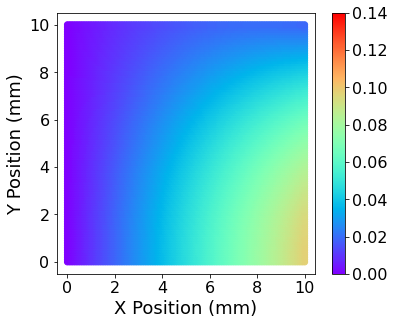

In [20]:
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c = u1, vmin=0, vmax=0.14, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf)
cb.ax.locator_params(nbins=7)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
#plt.savefig('Flat-U-PDE-5-5.png', dpi=600, transparent=True)
plt.show()

In [21]:
_, du_x, du_y,= derivative(X_train, Net_u, func_u, '1')
_, dv_x, dv_y,= derivative(X_train, Net_v, func_v, '1')

sig_x = (du_x + mu*dv_y)*E/(1 - mu**2)
sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
sig_xy = (dv_x + du_y)*E/(1 + mu)/2.

sig_x = sig_x.detach().numpy()
sig_y = sig_y.detach().numpy() 
sig_xy = sig_xy.detach().numpy()

In [22]:
np.corrcoef(sig11.reshape(1,-1), sig_x.reshape(1,-1))

array([[1.        , 0.99292426],
       [0.99292426, 1.        ]])

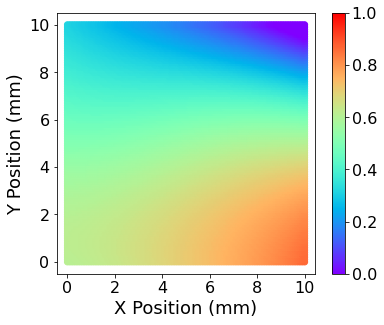

In [23]:
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c = sig_x, vmin=0., vmax=1.0, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf)
cb.ax.locator_params(nbins=7)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
#plt.savefig('Flat-S-PDE-5-5.png', dpi=600, transparent=True)
plt.show()

In [24]:
data_out = np.hstack([X.reshape(-1,1),Y.reshape(-1,1),u1,u2,sig_x,sig_y,sig_xy])
df_out = pd.DataFrame(data_out, columns=['X', 'Y', 'U', 'V', 'Sig_x', 'Sig_y', 'Sig_xy'])

In [81]:
df_out.to_csv('Flat-PDE-5-5-W10.csv')